# Unmixing_1: Machine Learning

In this notebook, we will explore classical spectral unmixing methods.  
We start with the techniques implemented in Hyperspy, namely ICA and MNF, and then move on to Vertex Component Analysis (VCA). 
The goal is to separate the mixed spectra into physically meaningful components and obtain corresponding abundance maps. We will use the same dataset that was previously analyzed during the clustering exercises, allowing us to directly compare results and gain insight into the spatial distribution of the different compounds in the sample.

⚠️ Note for the reader

This notebook contains extended comments and explanations to make it as self-contained as possible. You do not need to read everything at once to follow the main steps. The detailed notes are meant to provide context, clarify methods, and address common questions, especially regarding assumptions, noise, and algorithmic choices. Feel free to skip or come back later to these sections if you want a quicker overview.

⚠️ **Warning**  
This notebook was tested with **HyperSpy 1.6.5** and  **HyperSpy 1.7.6**
With the current version **HyperSpy 2.3.0**, some functions, syntax, or behaviors may have changed.  
As a result, this notebook **may not run properly** without adjustments.

⚙️ **Environment used:**  
- Python 3.9.21  
- numpy 1.24.4 
- scikit-learn 1.6.0   
- hyperspy 1.7.6
- matplotlib: 3.5.3

In [1]:
# %matplotlib qt
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt

import sys
import os

In [2]:
# we will use the same set of data as for Notebook 1 and Notebook 2
# ⚠️ MODIFY this line according to your own path
# load data
data_matrix = np.load(r'C:\Users\brun\Documents\Donnees\AutumnSchool_AI_in_Electron_Microscopy2025\DataSets\Raw_MnOFeO_NP_coreLoss.npy')

In [3]:
# we are going to use Hyperspy so we transform the data into Hyperspy format
s_raw = hs.signals.Signal1D(data_matrix)

C:\Users\brun\AppData\Local\miniconda3\envs\Hyperspy_env_clone\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# we cut a part of the energy channels
# we also need to correct some negative values in the dataset
mini = np.min(data_matrix)
s = s_raw.isig[500:1580] -  mini

In [5]:
# we perfom PCA decomposition
s.decomposition(True)

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None


<AxesSubplot:title={'center':'\nPCA Scree Plot'}, xlabel='Principal component index', ylabel='Proportion of variance'>

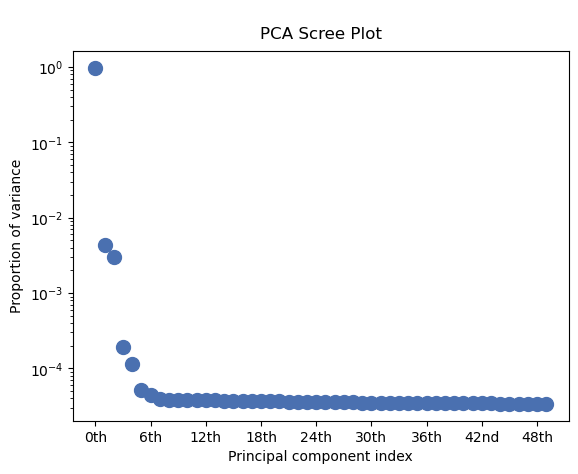

In [6]:
s.plot_explained_variance_ratio(n=50) 

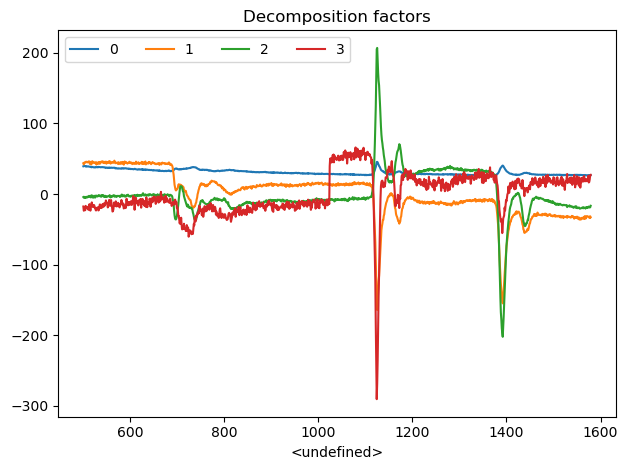

In [7]:
s.plot_decomposition_factors(4);

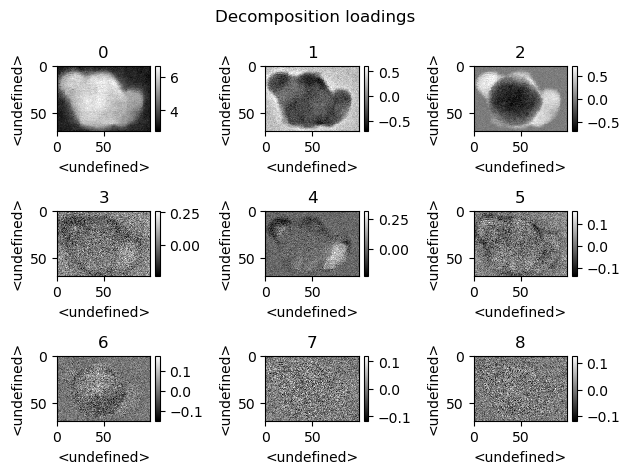

In [8]:
s.plot_decomposition_loadings(9);

The components extracted by PCA are typically not physically interpretable. So we need to use another constraint to perform the decomposition.

## Independent Component Analysis (ICA)
ICA is a computational technique used to separate a multivariate signal into additive, statistically independent components. Unlike PCA, which focuses on uncorrelated components, ICA aims to find components that are as statistically independent as possible. This technique is particularly useful in spectral unmixing, where it can identify distinct spectral signatures (endmembers) by separating mixed signals into their underlying sources.

In [9]:
# we perform the unmixing (some communities rather use the word "separation")
# we get a warning message suggesting to increase the number of iteration
# max_iter and tol are absent from the Hyperspy doc and you have to consult scikit documentation
s.blind_source_separation(5, max_iter=5000, tol = 0.001) 

[########################################] | 100% Completed | 114.24 ms


Blind source separation info:
  number_of_components=5
  algorithm=sklearn_fastica
  diff_order=1
  reverse_component_criterion=factors
  whiten_method=PCA
scikit-learn estimator:
FastICA(max_iter=5000, tol=0.001, whiten=False)


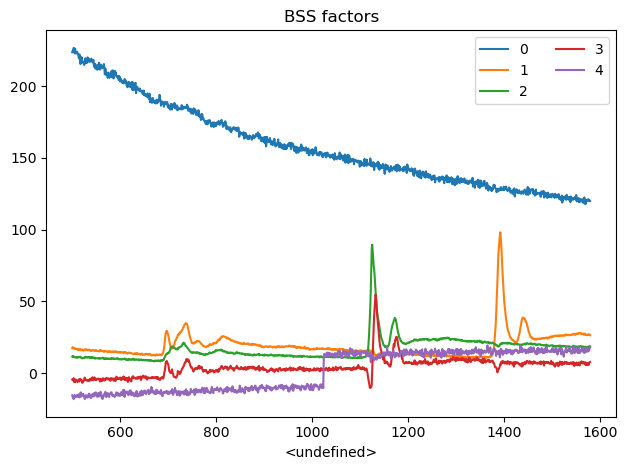

In [10]:
s.plot_bss_factors();

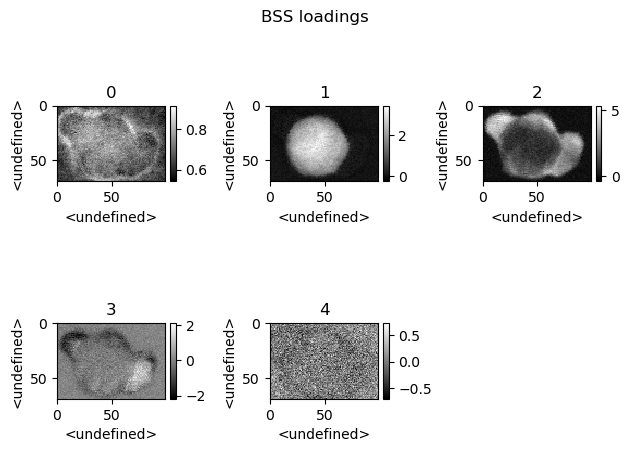

In [11]:
s.plot_bss_loadings();

In this case, the unmixing (separation) process has quickly provided results that align with what is known about the sample’s structure and match the reference spectra of the known components. However, there is a strange component interpreted in the original paper as a "detector intensity step".  

This performance of the unmixing contrasts with the challenges faced earlier during the clustering process, where the results were less physically meaningful, and tuning hyperparameters was necessary. Moreover, unmixing offers a much richer insight into the spatial distribution of the different components present in the sample. Other unmixing methods exist, either within the Hyperspy framework or derived from other sources.

## Non-Negative Matrix Factorization (NMF).


Non-negative Matrix Factorization (NMF) is a matrix decomposition technique that factorizes a given matrix into two matrices, with all non-negative elements, (W, H) whose product approximates the non-negative matrix X.  

Because it enforces non-negativity, NMF is particularly suitable for spectral unmixing of EELS data, where both spectra and abundances represent physical quantities.
NMF actually refers to a family of algorithms with various optimization options — see the documentation of HyperSpy and scikit-learn for examples and implementation details.

In [12]:
# we can also use NMF
# 🐢 SLOW CELL
s.decomposition(True, algorithm='NMF', output_dimension=5, max_iter=5000)

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=NMF
  output_dimension=5
  centre=None
scikit-learn estimator:
NMF(max_iter=5000, n_components=5)


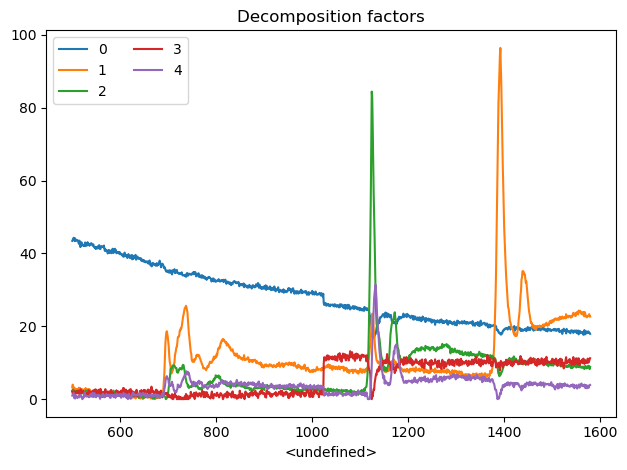

In [13]:
# plot the decomposition factors
s.plot_decomposition_factors();

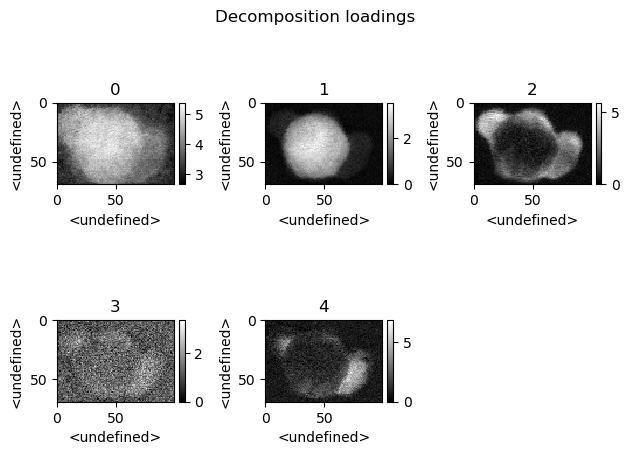

In [14]:
# plot decomposition maps
s.plot_decomposition_loadings();

## Vertex Component Analysis (VCA)  
VCA is primarily rooted in the remote sensing community, where it has been widely applied to analyze satellite and airborne hyperspectral data.
VCA is a method used for spectral unmixing that relies on identifying the 'vertices' of the data, which represent the extreme points of the convex hull in the high-dimensional space. VCA is particularly effective when dealing with hyperspectral data, as it helps to identify the endmembers, or pure spectral signatures, from mixed pixels. By leveraging the geometry of the data, VCA works well in scenarios where the data points lie on or near a convex hull, such as in the case of hyperspectral imaging of materials with well-defined spectral features.  

VCA determines the endmembers, so we need a separate algorithm to estimate the abundances of each endmember in the mixed pixels. Many commonly available algorithms for abundance estimation do not account for the Poisson noise present in EELS data. Despite this limitation, VCA and subsequent abundance estimation algorithms still tend to work reasonably well in practice, often providing useful results even when the noise characteristics are not fully accounted for.

Another key advantage of VCA is its computational speed. Even when dealing with highly mixed pixels, VCA can quickly identify the most dominant endmember for each pixel, which corresponds to the purest spectral component. This component can then be interpreted physically, offering insight into the material composition of the sample. The simplicity and efficiency of VCA make it an attractive choice for real-time applications or large datasets where processing time is critical.


In [15]:
#  VCA imports
from VCA import *
from sunsal import *

In [16]:
nrow = data_matrix.shape[0]
ncol = data_matrix.shape[1]
nband = data_matrix.shape[2]

# flatten the data cube

data_flat_total = data_matrix.reshape((nrow*ncol, nband)).transpose()
print(data_flat_total.shape)
data_flat = data_flat_total[500:1580, :]

(1730, 7000)


SNR estimated = 15.516290913005651[dB]
... Select proj. to R-1


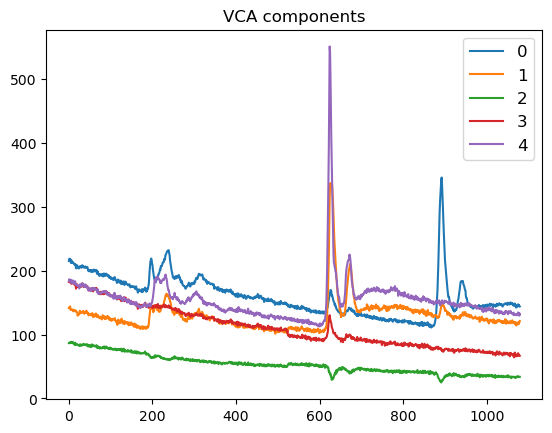

In [17]:
############################################################
# PART I : find endmembers with VCA
############################################################

# Choosing the number of endmembers
R = 5

# VCA
Ae, indice, Yp = vca(data_flat,R,verbose = True,snr_input = 0)

# plot
plt.figure()
for r in range(0, R):
    plt.plot(Ae[:, r], label=r)
    
plt.title("VCA components")
plt.legend(fontsize='large')

SUNSAL (Sparse Unmixing via Variable Splitting and Augmented Lagrangian) is an algorithm designed to solve the linear unmixing problem under sparsity constraints. Given a set of endmembers M and observed spectra Y, SUNSAL estimates the abundance vectors A by minimizing the reconstruction error while promoting sparse solutions.

Key points:

- Works well when each pixel contains only a few active endmembers.

- uses variable splitting (introduces auxiliary variables to handle constraints more easily) and an augmented Lagrangian (adds penalty terms to enforce constraints) to efficiently handle constraints such as non-negativity and sum-to-one.

 - very fast and robust for hyperspectral images, though it assumes that the endmembers are known.

SUNSAL does not explicitly model the Poisson noise typical of EELS data, but in practice the abundance estimates are often still accurate. This can be partly justified by the high redundancy in the spectra and the relative smoothing effect of the linear unmixing: even if the noise distribution is not Gaussian, the algorithm tends to find the “average” contributions that minimize reconstruction error.

In [18]:
#  FCLS - Fully constrained least squares (lambda >=0 , POSITIVITY = True, ADDONE, True) 
# In this case, the regularizer ||X||_1 plays no role, as it is constant.
# Ae - [L(channels) x p(endmembers)] endmembers matrix
# y - pixels matrix with L(channels) x N(pixels). each pixel is a linear mixture of p endmembers signatures y = M*x + noise,



# sunsal
x,res_p,res_d,i = sunsal(Ae,data_flat,AL_iters=1000,lambda_0=1.,positivity=True,addone=True,tol=1e-4,x0 = None,verbose=False)

# Output :
# x - estimated mixing matrix [pxN] 
# res_p - primal residual res_d - dual residual 
#i - number of iteration until convergence

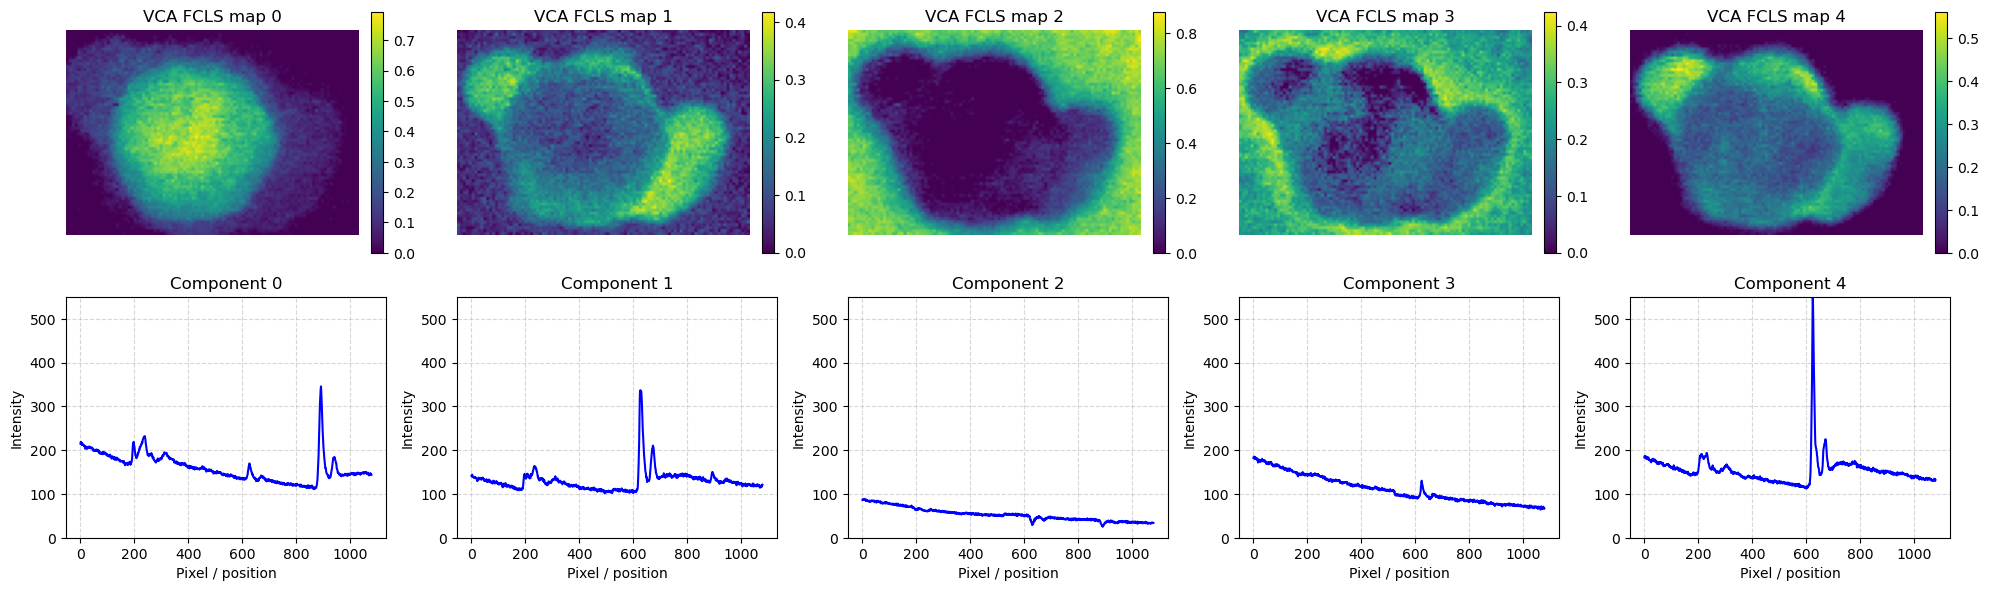

In [19]:
# results visualization
xt = x.T  # transpose
fig, axes = plt.subplots(2, R, figsize=(4*R, 6))

if R == 1:
    axes = axes.reshape(2,1)

max_intensity = max([Ae[:, r].max() for r in range(R)])

for r in range(R):
    # ---- Maps ----
    map1 = xt[:, r].reshape(nrow, ncol)
    im = axes[0, r].imshow(map1, cmap='viridis')
    axes[0, r].set_title(f"VCA FCLS map {r}", fontsize=12)
    axes[0, r].axis('off')
    fig.colorbar(im, ax=axes[0, r], fraction=0.046, pad=0.04)
    
    # ---- Components ----
    axes[1, r].plot(Ae[:,r], color='blue')
    axes[1, r].set_title(f"Component {r}", fontsize=12)
    axes[1, r].set_xlabel("Pixel / position")
    axes[1, r].set_ylabel("Intensity")
    axes[1, r].set_ylim(0, max_intensity)
    axes[1, r].grid(True, ls='--', alpha=0.5)

plt.tight_layout()
plt.show()


## Conclusions

In this notebook, we applied three different spectral unmixing methods (ICA, NMF, and VCA) to the hyperspectral dataset.
All three approaches produced satisfactory and physically meaningful results, successfully recovering endmember spectra and abundance maps consistent with the expected chemical components.

These results highlight the power of spectral unmixing for EELS data analysis, especially after the difficulties encountered with clustering in the previous notebook.
While clustering mainly groups spectra based on overall similarity, unmixing provides a more interpretable decomposition of the data, revealing how multiple signals contribute to each pixel.

In the next Notebook, autoencoders approaches will be explored to combine the interpretability of classical methods with the flexibility of deep learning.